In [1]:
import torch
from torch import nn
from src.data import get_data
from src.models import get_encoder, get_decoder
from src.utils import softclip
from src.hessian import laplace
import yaml
from copy import deepcopy
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import os


def get_model(encoder, decoder):
    
    net = deepcopy(encoder.encoder._modules)
    decoder = decoder.decoder._modules
    max_ = max([int(i) for i in net.keys()])
    for i in decoder.keys():
        net.update({f"{max_+int(i) + 1}": decoder[i]})

    return nn.Sequential(net)

c:\Users\nsde\Anaconda3\envs\laplace\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load checkpoints for the different models

In [2]:
#path_ae = "../weights/mnist/ae_[use_var_dec=False]"
path_ae = "../weights/mnist/ae_[use_var_dec=False]/[no_conv_True]_[use_var_decoder_False]_"
with open(f"{path_ae}/config.yaml") as file:
    config = yaml.full_load(file)
ae_encoder = get_encoder(config, latent_size=2)
ae_encoder.load_state_dict(torch.load(f"{path_ae}/encoder.pth"))

path_mcae = "../weights/mnist/mcdropout_ae"
with open(f"{path_mcae}/config.yaml") as file:
    config = yaml.full_load(file)
mcae_encoder = get_encoder(config, latent_size=2, dropout=config["dropout_rate"])
mcae_encoder.load_state_dict(torch.load(f"{path_mcae}/encoder.pth"))

#path_vae = "../weights/mnist/vae_[use_var_dec=False]"
path_vae = "../weights/mnist/vae_[use_var_dec=False]/[no_conv_True]_[use_var_decoder_False]_"
with open(f"{path_vae}/config.yaml") as file:
    config = yaml.full_load(file)
vae_encoder_mu = get_encoder(config, latent_size=2)
vae_encoder_mu.load_state_dict(torch.load(f"{path_vae}/mu_encoder.pth"))
vae_encoder_var = get_encoder(config, latent_size=2)
vae_encoder_var.load_state_dict(torch.load(f"{path_vae}/var_encoder.pth"))

#path_lae = "../weights/mnist/lae_elbo/[backend_layer]_[approximation_exact]_[no_conv_True]_[train_samples_10]_/"
#path_lae = "../weights/mnist/lae_elbo/[backend_layer]_[approximation_exact]_[no_conv_True]_[train_samples_1]_"
#path_lae="../weights/mnist/lae_model_selection_7_may/weights_mnist_model_selection/1[backend_layer]_[approximation_exact]_[no_conv_True]_[train_samples_1]_"
path_lae="../weights/mnist/lae_elbo/mem_0999_prior_prec_1_scale_1[backend_layer]_[approximation_exact]_[no_conv_True]_[train_samples_1]_"
with open(f"{path_lae}/config.yaml") as file:
    config = yaml.full_load(file)
lae_encoder = get_encoder(config, latent_size=2)
lae_decoder = get_decoder(config, latent_size=2)
lae_net = get_model(lae_encoder, lae_decoder).eval()
lae_net.load_state_dict(torch.load(f"{path_lae}/net.pth"))
mu_q = parameters_to_vector(lae_net.parameters()).cuda()
l = laplace.DiagLaplace()
h = torch.load(f"{path_lae}/hessian.pth").cpu()
sigma_q = l.posterior_scale(h).cuda()

# Construct function for loading subset of validation data

In [3]:
_, val_dataloader = get_data("mnist")
images, labels = [ ], [ ]

for batch in val_dataloader:
    x, y = batch
    images.append(x)
    labels.append(y)
images = torch.cat(images, 0)
labels = torch.cat(labels, 0)

n_select = 5 # select this many datapoints from each class

def get_dataset(n_select):
    selected_images = torch.zeros(10*n_select, 1, 28, 28)
    selected_labels = torch.zeros(10*n_select,)
    eval_set_images = torch.zeros(images.shape[0]-10*n_select, 1, 28, 28)
    eval_set_labels = torch.zeros(images.shape[0]-10*n_select, )

    count = 0
    for i in range(10):
        idx = torch.where(labels == i)[0]
        n = len(idx)
        rand_idx = torch.randperm(n)

        selected_images[i*n_select:(i+1)*n_select] = images[idx[rand_idx[:n_select]]]
        selected_labels[i*n_select:(i+1)*n_select] = labels[idx[rand_idx[:n_select]]]
        eval_set_images[count:count+len(rand_idx[n_select:])] = images[idx[rand_idx[n_select:]]]
        eval_set_labels[count:count+len(rand_idx[n_select:])] = labels[idx[rand_idx[n_select:]]]

        count += len(rand_idx[n_select:])
    return selected_images, selected_labels, eval_set_images, eval_set_labels

selected_images, selected_labels, eval_set_images, eval_set_labels = get_dataset(n_select)

# just for testing purpose
eval_set_images = eval_set_images[:500]
eval_set_labels = eval_set_labels[:500]

print(selected_images.shape)
print(selected_labels.shape)
print(eval_set_images.shape)
print(eval_set_labels.shape)


torch.Size([50, 1, 28, 28])
torch.Size([50])
torch.Size([500, 1, 28, 28])
torch.Size([500])


# Construct functions for embedding data into representation space for the different models

In [4]:
def get_encoding_ae(data, n=1):
    return ae_encoder(data)

print('standard ae')
print(get_encoding_ae(images[:1]))

def get_encoding_mcae(data, n=1):
    return torch.cat([mcae_encoder(data) for _ in range(n)], 0)

print('monte-carlo ae')
print(get_encoding_mcae(images[:1], n=2))

def get_encoding_vae(data, n=1):
    mu = vae_encoder_mu(data)
    sigma = torch.exp(softclip(vae_encoder_var(data), min=-3))
    return torch.cat([mu + torch.randn_like(sigma) * sigma for _ in range(n)])

print('vae')
print(get_encoding_vae(images[:1], n=2))

def sample():
    return (mu_q + torch.randn_like(sigma_q) * sigma_q).cpu()
    
def get_encoding_lae(data, n=1):
    embeddings = [ ]
    def fw_hook_get_latent(module, input, output):
        embeddings.append(output.detach().cpu())
    hook = lae_net[5].register_forward_hook(fw_hook_get_latent)

    if n == 1:
        _ = lae_net(data)
        hook.remove()
        return embeddings[0]

    for i in range(n):
        vector_to_parameters(sample(), lae_net.parameters())
        _ = lae_net(data)
    hook.remove()
    return torch.cat(embeddings, 0)

print('lae')
print(get_encoding_lae(images[:1], n=2))

standard ae
tensor([[-8.3567,  2.6312]], grad_fn=<AddmmBackward>)
monte-carlo ae
tensor([[-1.6881,  3.0270],
        [-2.0324,  3.2310]], grad_fn=<CatBackward>)
vae
tensor([[ 0.3042, -0.5828],
        [-0.5804,  0.7890]], grad_fn=<CatBackward>)
lae
tensor([[-17.5540, -10.7496],
        [-17.6562, -10.7085]])


# Run experiment

In [5]:
with torch.inference_mode():
    scale_factor = 100
    names = ['ae', 'mcae', 'vae', 'lae']
    label_size = [1, 2, 4, 6, 8, 10, 15, 25, 50, 100]
    reps = 5

    res = np.zeros((reps, len(label_size), len(names)))
    for r in range(reps):
        for i, n_select in enumerate(label_size):
            selected_images, selected_labels, eval_set_images, eval_set_labels = get_dataset(n_select)
            for j, (name, encoder) in enumerate(zip(names, [get_encoding_ae, get_encoding_mcae, get_encoding_vae, get_encoding_lae])):
                print(r,i,j)
                eval_data = torch.cat([encoder(d) for d in eval_set_images], 0)
                train_data = torch.cat([encoder(d, scale_factor) for d in selected_images], 0)
                train_labels = selected_labels.repeat_interleave(scale_factor) if name != 'ae' else selected_labels
                if n_select < 2:
                    classifier = KNeighborsClassifier(1)
                else:
                    classifier = GridSearchCV(
                        KNeighborsClassifier(),
                        {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
                        cv=2,
                        refit=True,
                    )
                classifier.fit(train_data.detach().numpy(), train_labels.detach().numpy())
                preds = classifier.predict(eval_data.detach().numpy())
                acc = (preds == eval_set_labels.numpy()).mean()
                res[r,i,j] = acc

0 0 0
0 0 1
0 0 2
0 0 3
0 1 0
0 1 1
0 1 2
0 1 3
0 2 0
0 2 1
0 2 2
0 2 3
0 3 0
0 3 1
0 3 2
0 3 3
0 4 0
0 4 1
0 4 2
0 4 3
0 5 0
0 5 1
0 5 2
0 5 3
0 6 0
0 6 1
0 6 2
0 6 3
0 7 0
0 7 1
0 7 2
0 7 3
0 8 0
0 8 1
0 8 2
0 8 3
0 9 0
0 9 1
0 9 2
0 9 3
1 0 0
1 0 1
1 0 2
1 0 3
1 1 0
1 1 1
1 1 2
1 1 3
1 2 0
1 2 1
1 2 2
1 2 3
1 3 0
1 3 1
1 3 2
1 3 3
1 4 0
1 4 1
1 4 2
1 4 3
1 5 0
1 5 1
1 5 2
1 5 3
1 6 0
1 6 1
1 6 2
1 6 3
1 7 0
1 7 1
1 7 2
1 7 3
1 8 0
1 8 1
1 8 2
1 8 3
1 9 0
1 9 1
1 9 2
1 9 3
2 0 0
2 0 1
2 0 2
2 0 3
2 1 0
2 1 1
2 1 2
2 1 3
2 2 0
2 2 1
2 2 2
2 2 3
2 3 0
2 3 1
2 3 2
2 3 3
2 4 0
2 4 1
2 4 2
2 4 3
2 5 0
2 5 1
2 5 2
2 5 3
2 6 0
2 6 1
2 6 2
2 6 3
2 7 0
2 7 1
2 7 2
2 7 3
2 8 0
2 8 1
2 8 2
2 8 3
2 9 0
2 9 1
2 9 2
2 9 3
3 0 0
3 0 1
3 0 2
3 0 3
3 1 0
3 1 1
3 1 2
3 1 3
3 2 0
3 2 1
3 2 2
3 2 3
3 3 0
3 3 1
3 3 2
3 3 3
3 4 0
3 4 1
3 4 2
3 4 3
3 5 0
3 5 1
3 5 2
3 5 3
3 6 0
3 6 1
3 6 2
3 6 3
3 7 0
3 7 1
3 7 2
3 7 3
3 8 0
3 8 1
3 8 2
3 8 3
3 9 0
3 9 1
3 9 2
3 9 3
4 0 0
4 0 1
4 0 2
4 0 3
4 1 0
4 1 1
4 1 

# Plot results

(10, 4)


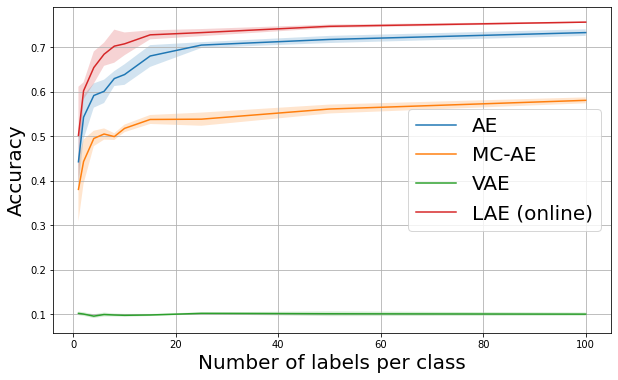

In [38]:
res_mean = res.mean(axis=0)
res_std = res.std(axis=0)
print(res_mean.shape)

fig = plt.figure(figsize=(10,6))
plt.plot(label_size, res_mean[:,0], label='AE')
plt.fill_between(label_size, res_mean[:,0] + res_std[:,0], res_mean[:,0] - res_std[:,0], alpha=0.2)
plt.plot(label_size, res_mean[:,1], label='MC-AE')
plt.fill_between(label_size, res_mean[:,1] + res_std[:,1], res_mean[:,1] - res_std[:,1], alpha=0.2)
plt.plot(label_size, res_mean[:,2], label='VAE')
plt.fill_between(label_size, res_mean[:,2] + res_std[:,2], res_mean[:,2] - res_std[:,2], alpha=0.2)
plt.plot(label_size, res_mean[:,3], label='LAE (online)')
plt.fill_between(label_size, res_mean[:,3] + res_std[:,3], res_mean[:,3] - res_std[:,3], alpha=0.2)
plt.legend(fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Number of labels per class', fontsize=20)
plt.grid()
plt.savefig('results.png', dpi=500)